In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
from nltk.corpus import stopwords
from nltk import word_tokenize

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
df = pd.read_csv('gdrive/MyDrive/Consumer_Complaints.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025010 entries, 0 to 1025009
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Date received                 1025010 non-null  object 
 1   Product                       1025010 non-null  object 
 2   Sub-product                   789840 non-null   object 
 3   Issue                         1025010 non-null  object 
 4   Sub-issue                     528853 non-null   object 
 5   Consumer Complaint            277814 non-null   object 
 6   Company Public Response       318364 non-null   object 
 7   Company                       1025010 non-null  object 
 8   State                         1012650 non-null  object 
 9   ZIP code                      1008292 non-null  object 
 10  Tags                          141588 non-null   object 
 11  Consumer consent provided?    491911 non-null   object 
 12  Submitted via               

In [7]:
df=df.head(50000)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 50000 non-null  object 
 1   Product                       50000 non-null  object 
 2   Sub-product                   35109 non-null  object 
 3   Issue                         50000 non-null  object 
 4   Sub-issue                     21052 non-null  object 
 5   Consumer Complaint            10663 non-null  object 
 6   Company Public Response       13488 non-null  object 
 7   Company                       50000 non-null  object 
 8   State                         49599 non-null  object 
 9   ZIP code                      49597 non-null  object 
 10  Tags                          6861 non-null   object 
 11  Consumer consent provided?    20155 non-null  object 
 12  Submitted via                 50000 non-null  object 
 13  D

In [9]:
df = df[pd.notnull(df['Consumer Complaint'])]

In [10]:
col = ['Product', 'Consumer Complaint']
df = df[col]

In [11]:
df.columns = ['Product', 'Complaints']


In [12]:
df.Product.value_counts()


Debt collection                                                                 2580
Mortgage                                                                        2098
Credit reporting                                                                2025
Credit card                                                                     1226
Bank account or service                                                          933
Student loan                                                                     764
Consumer Loan                                                                    600
Payday loan                                                                      110
Money transfers                                                                  103
Prepaid card                                                                      89
Credit reporting, credit repair services, or other personal consumer reports      64
Other financial service                                          

In [13]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [14]:
for product_name in df['Product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in df.loc[df['Product'].str.contains(product_name),'Complaints']])
    from wordcloud import WordCloud
    
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
def print_plot(index):
    example = df[df.index == index][['Complaints', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

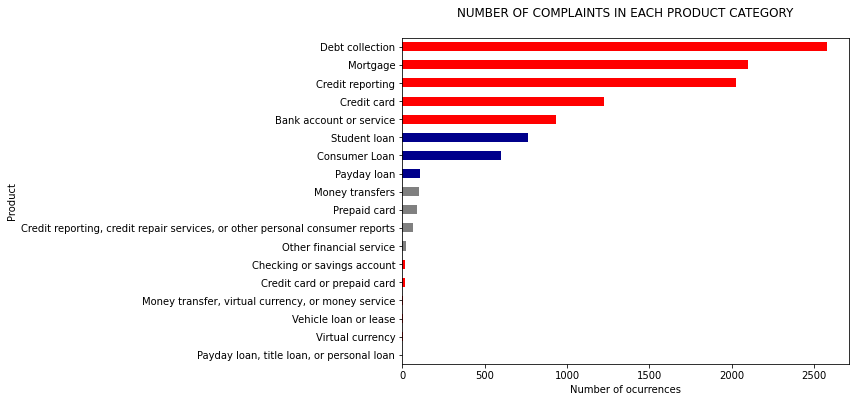

In [16]:
fig = plt.figure(figsize=(8,6))
colors = ['red','red','red','red','red','red','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('Product').Complaints.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [17]:
print_plot(2)

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had been paid in full ( dated XXXX, XXXX ) but no refund check was included. XXXX stated that they hold any over payment for 10 business days after the loan was satisfied and that my check would be mailed ou

In [18]:
print_plot(1)


I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements
Product: Credit reporting


In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 60000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 270
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Complaints'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21782 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['Complaints'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10663, 270)


In [21]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10663, 18)


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7997, 270) (7997, 18)
(2666, 270) (2666, 18)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout, Lambda
from keras.layers.embeddings import Embedding
import tensorflow as tf

In [24]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 270, 100)          6000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 270, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 6,082,218
Trainable params: 6,082,218
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
epochs = 6
batch_size = 20

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/6
360/360 [==============================] - 208s 569ms/step - loss: 2.0201 - accuracy: 0.2625 - val_loss: 1.9804 - val_accuracy: 0.2875
Epoch 2/6
360/360 [==============================] - 206s 573ms/step - loss: 1.7083 - accuracy: 0.4205 - val_loss: 1.7366 - val_accuracy: 0.3738
Epoch 3/6
360/360 [==============================] - 206s 572ms/step - loss: 1.4285 - accuracy: 0.5338 - val_loss: 1.4988 - val_accuracy: 0.5113
Epoch 4/6
360/360 [==============================] - 206s 572ms/step - loss: 1.1661 - accuracy: 0.6293 - val_loss: 1.6454 - val_accuracy: 0.4988
Epoch 5/6
360/360 [==============================] - 206s 572ms/step - loss: 1.0255 - accuracy: 0.6890 - val_loss: 1.2344 - val_accuracy: 0.6087
Epoch 6/6
360/360 [==============================] - 206s 571ms/step - loss: 0.7973 - accuracy: 0.7666 - val_loss: 1.1725 - val_accuracy: 0.6550


In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

84/84 [==============================] - 7s 76ms/step - loss: 1.1374 - accuracy: 0.6609
Test set
  Loss: 1.137
  Accuracy: 0.661


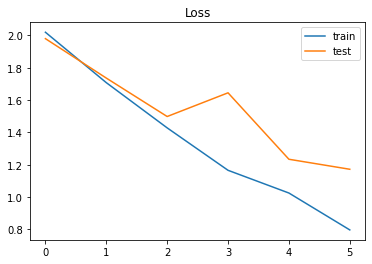

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

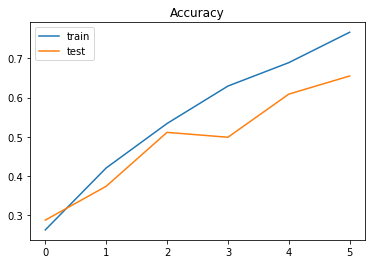

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [29]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.96116254e-01 3.23761068e-03 1.17636118e-02 6.87329292e-01
  2.05145683e-03 2.94323824e-02 3.95038910e-03 1.12465844e-02
  1.29884516e-03 1.33793345e-02 4.70799673e-03 2.54290993e-03
  5.29174274e-03 1.14580813e-04 2.59235781e-02 1.17432291e-03
  2.79181200e-04 1.59934920e-04]] Credit card or prepaid card


In [30]:
epochs = 20
batch_size = 40

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/20
180/180 [==============================] - 126s 698ms/step - loss: 0.6110 - accuracy: 0.8258 - val_loss: 1.0456 - val_accuracy: 0.6925
Epoch 2/20
180/180 [==============================] - 126s 698ms/step - loss: 0.5497 - accuracy: 0.8437 - val_loss: 1.0581 - val_accuracy: 0.7088
Epoch 3/20
180/180 [==============================] - 126s 698ms/step - loss: 0.4653 - accuracy: 0.8691 - val_loss: 1.1083 - val_accuracy: 0.7013
Epoch 4/20
180/180 [==============================] - 126s 697ms/step - loss: 0.4322 - accuracy: 0.8806 - val_loss: 1.1488 - val_accuracy: 0.6975


In [31]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

84/84 [==============================] - 6s 76ms/step - loss: 1.0992 - accuracy: 0.7007
Test set
  Loss: 1.099
  Accuracy: 0.701


In [33]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.4604660e-02 4.9372960e-04 2.4078256e-03 9.6241134e-01 5.9064687e-04
  5.5866819e-03 8.4771257e-04 3.2748033e-03 2.4108759e-04 1.5561228e-03
  6.3995447e-04 3.5543076e-04 1.0004545e-03 3.6030426e-06 5.9183012e-03
  4.6631889e-05 1.0648842e-05 1.0487137e-05]] Credit card or prepaid card
